### 1. Import Dependencies

In [1]:
import torch
print(torch.cuda.is_available())  # Should return True if CUDA is available
print(torch.cuda.device_count())  # Number of available GPUs
#print(torch.cuda.current_device())  # Current device being used by CUDA


True
1


In [2]:
#import torch
import clip
import os
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import ipywidgets as widgets
from IPython.display import display
import io
import tkinter as tk
from PIL import Image, ImageTk


# Load the CLIP model (ViT-B/32 is the default)
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)


### 3. Extract Image Features

In [3]:
def extract_image_features(image_path):
    image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
    with torch.no_grad():
        image_features = model.encode_image(image)
    return image_features / image_features.norm(dim=-1, keepdim=True)  # Normalize

In [ ]:
def img_embed_new(device, image_features_dict):
    # Load images and compute embeddings
    image_folder = "illustration_dataset"
    embedding_file = "backup_image_embeddings.pt"

    if os.path.exists(embedding_file):
        print(f"Loading embeddings from '{embedding_file}'...")
        image_features_dict = torch.load(embedding_file, map_location=device)
        print(f"Loaded {len(image_features_dict)} embeddings from '{embedding_file}'.")
    else:
        image_features_dict = {}
        print(f"No existing embeddings found. Starting from scratch.")

    print("Scanning for image files in the folder...")
    image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(("png", "jpg", "jpeg"))]
    print(f"Found {len(image_files)} images in '{image_folder}'.")

    print("Scanning for new images...")
    new_images = [f for f in image_files if f not in image_features_dict]
    print(f"Found {len(new_images)} new images to process.")

    if not new_images:
        print("No new images to process.")
    else:
        for filename in tqdm(new_images, desc="Processing new images", unit="image"):
            image_path = os.path.join(image_folder, filename)
            image_features_dict[filename] = extract_image_features(image_path)

        # Step 5: Save image embeddings to a file
        print("Saving updated embeddings to 'image_embeddings_test.pt'...")
        torch.save(image_features_dict, "image_embeddings_test.pt")
        print("Image embeddings saved to 'image_embeddings_test.pt'.")

In [15]:
    # Load CLIP model
    device = "cpu"
    model, preprocess = clip.load("ViT-B/32", device="cpu")

    print(torch.cuda.is_available())  # Should return True if 
    print(torch.cuda.device_count())  # Number of available 

    # Load image embeddings
    image_features_dict = torch.load("image_embeddings.pt", map_location=torch.device('cpu'))

    img_embed_new(device, image_features_dict)

True
1
Loading embeddings from 'backup_image_embeddings.pt'...
Loaded 71091 embeddings from 'backup_image_embeddings.pt'.
Scanning for image files in the folder...
Found 71096 images in 'illustration_dataset'.
Scanning for new images...
Found 5 new images to process.


Processing new images: 100%|██████████| 5/5 [00:00<00:00,  8.70image/s]


Saving updated embeddings to 'image_embeddings_test.pt'...
Image embeddings saved to 'image_embeddings_test.pt'.


### 4. Extract Text Features

In [8]:
def extract_text_features(text):
    status = widgets.Label(value="Ready")
    display(status)

    status.value = f"Processing: {text}"  # Update status
    
    text_tokenized = clip.tokenize([text]).to(device)

    status.value = "Encoding text with CLIP..."
    with torch.no_grad():
        text_features = model.encode_text(text_tokenized)
    
    status.value = "Normalizing features..."
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)
    
    status.value = "Extraction complete!"
    return text_features

In [ ]:
# Example text prompts
text_prompts = ["fisheye perspective, black hair", "fantasy landscape", "cyberpunk city", "red hair", "hoodie"]

# Compute and save text embeddings
text_features_dict = {prompt: extract_text_features(prompt) for prompt in text_prompts}
torch.save(text_features_dict, "text_embeddings.pt")
print("Text embeddings saved to 'text_embeddings.pt'")

## Load Embeddings

In [4]:
if device == "cuda":
    # Load image embeddings
    image_features_dict = torch.load("image_embeddings.pt")

    # Load text embeddings
    text_features_dict = torch.load("text_embeddings.pt")
    
else:
    # Load image embeddings onto the CPU
    image_features_dict = torch.load("image_embeddings.pt", map_location=torch.device('cpu'))

    # Load text embeddings onto the CPU
    text_features_dict = torch.load("text_embeddings.pt", map_location=torch.device('cpu'))

In [ ]:
# # Load image embeddings
# image_features_dict = torch.load("image_embeddings.pt")

# # Load text embeddings
# text_features_dict = torch.load("text_embeddings.pt")

### 5. Comparison Computing

In [56]:
# Example query
query = "nerd"

#### Run

In [57]:
# Initialize status widget
status = widgets.Label(value="Ready")
display(status)

# Get the text features for the query
if query in text_features_dict:
    text_features = text_features_dict[query]
    status.value = f"Found cached features for: {query}"
else:
    status.value = f"Computing features for: {query}"
    text_features = extract_text_features(query)  # Compute features if not cached
    status.value = f"Features extracted for: {query}"

# Compute cosine similarity with a progress bar
status.value = "Computing cosine similarity..."
similarities = {}
for img_name, img_features in tqdm(image_features_dict.items(), desc="Computing Similarity"):
    similarities[img_name] = torch.cosine_similarity(text_features, img_features, dim=-1).item()

# Sort results by similarity
sorted_images = sorted(similarities.items(), key=lambda x: x[1], reverse=True)

# Display top matches
status.value = "Displaying top matches..."
for img, score in sorted_images[:8]:
    print(f"{img}: {score:.4f}")

status.value = "Completed!"

Label(value='Ready')

Label(value='Ready')

Computing Similarity: 100%|██████████| 71091/71091 [00:01<00:00, 57529.67it/s]

80642752_p0_master1200.jpg: 0.3025
85620721_p0_master1200.jpg: 0.2967
80844628_p0_master1200.jpg: 0.2946
79865771_p0_master1200.jpg: 0.2914
81601930_p0_master1200.jpg: 0.2907
81114598_p0_master1200.jpg: 0.2881
80087029_p0_master1200.jpg: 0.2881
79601836_p0_master1200.jpg: 0.2873


# Singular Displays

### Display Across

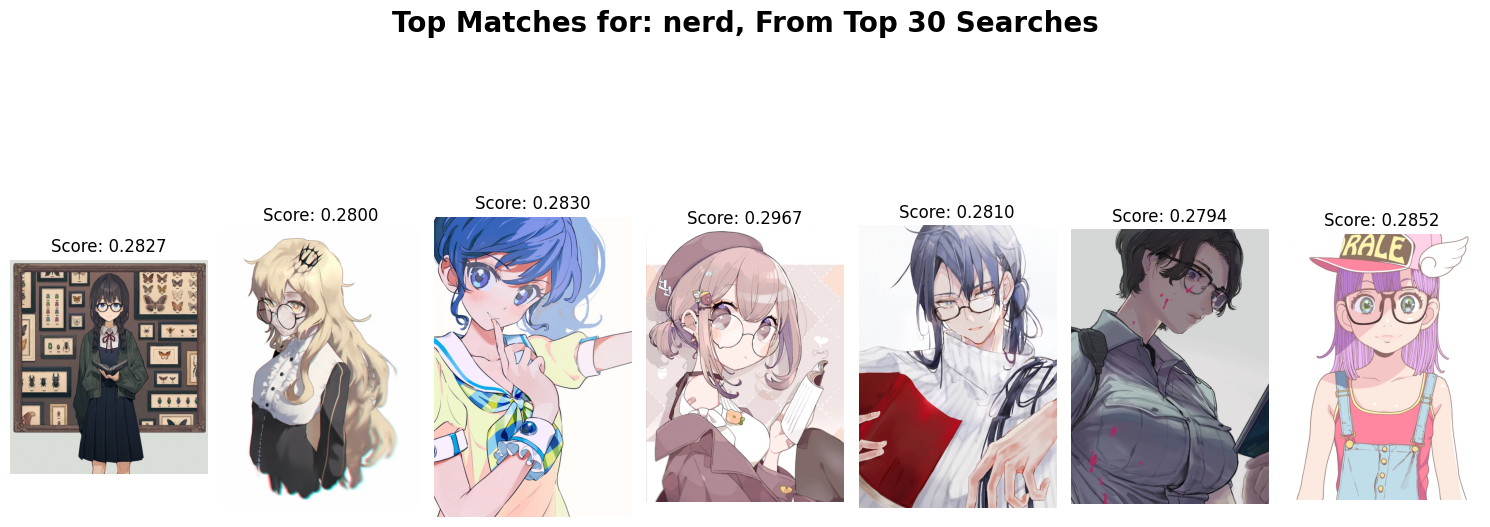

In [60]:
# Display top matches
top_k = 7  # Number of images to display
plt.figure(figsize=(15, 7))  # Set the figure size
image_folder = "illustration_dataset"

# Shuffle and pick random images from the top 50 results
top_n = 30  # Consider the top 50 instead of just top_k
random_subset = random.sample(sorted_images[:top_n], top_k)  # Pick top_k randomly
# Add a title to the entire plot
plt.suptitle(f"Top Matches for: {query}, From Top {top_n} Searches", fontsize=20, fontweight='bold')


for i, (img, score) in enumerate(random_subset):
    # Load the image
    image_path = os.path.join(image_folder, img)
    image = Image.open(image_path)
    
    # Plot the image
    plt.subplot(1, top_k, i + 1)
    plt.imshow(image)
    plt.title(f"Score: {score:.4f}")
    plt.axis('off')  # Hide axes

plt.subplots_adjust(top=0.55)
plt.tight_layout()
plt.show()

### Display Individual

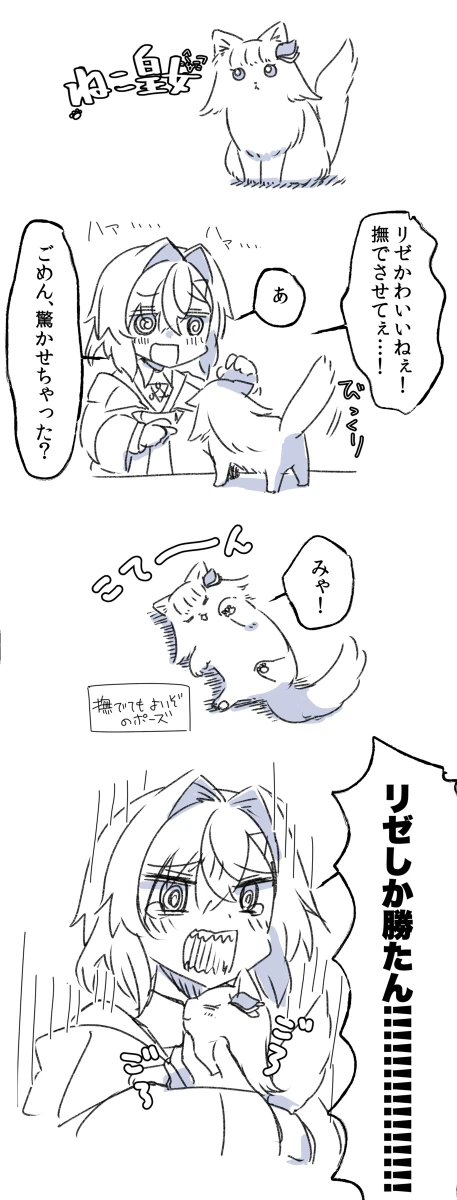

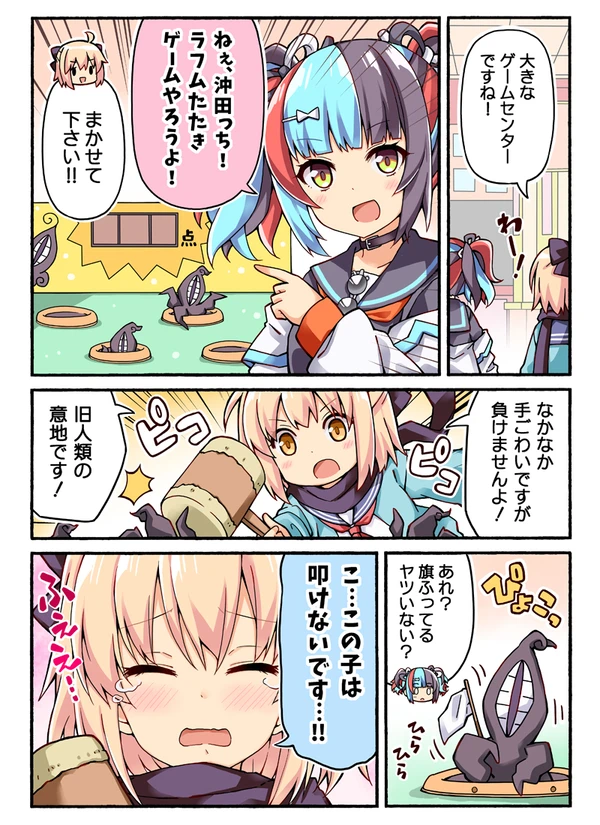

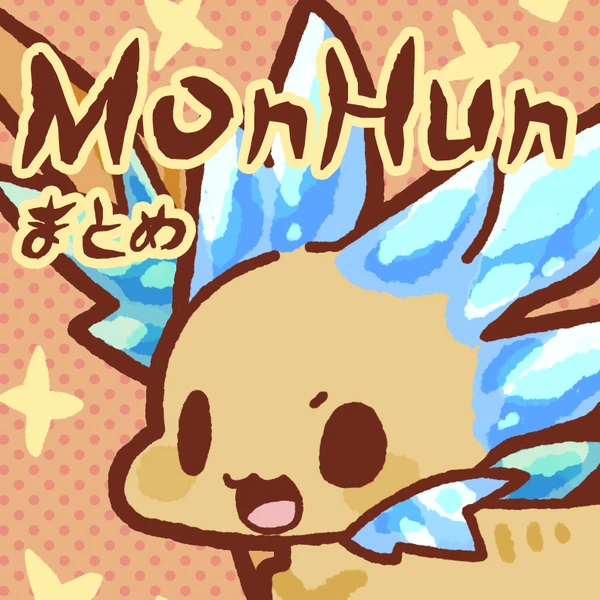

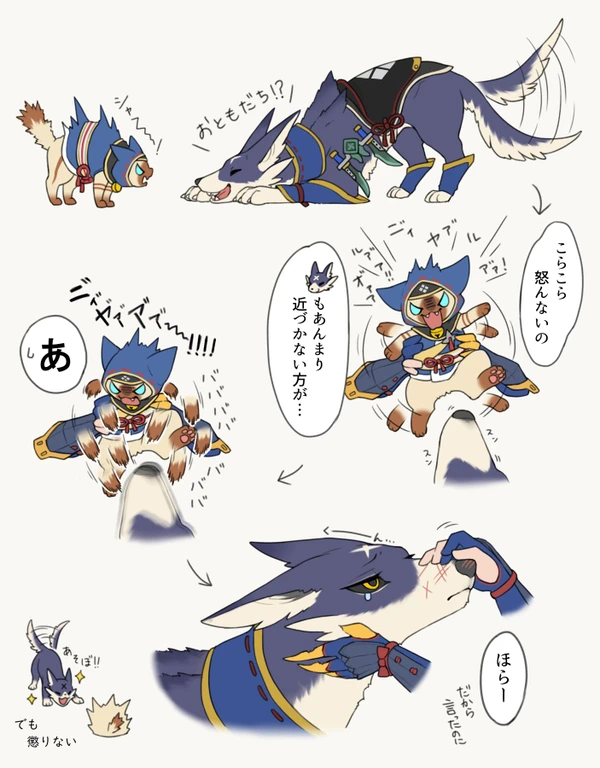

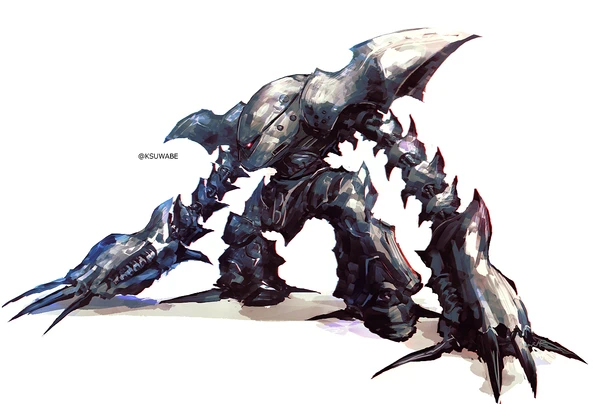

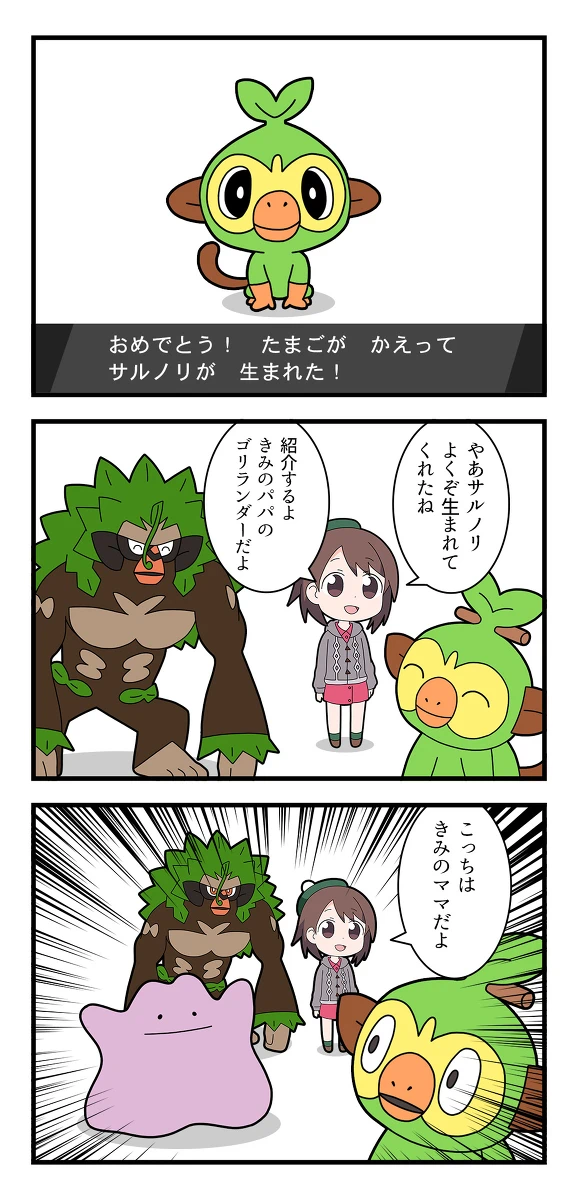

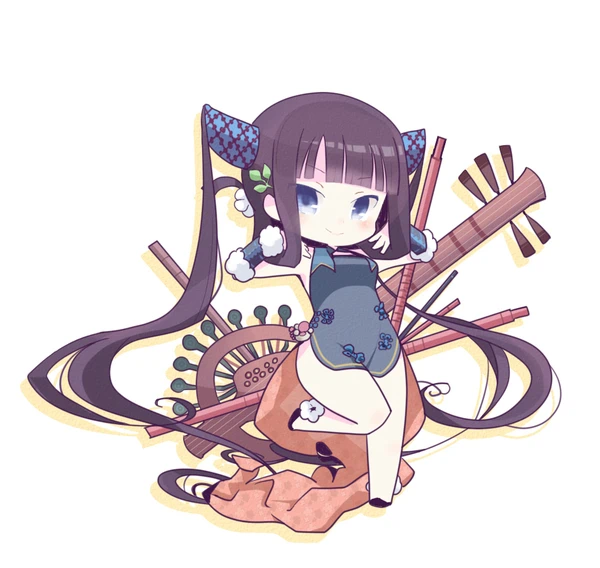

<Figure size 1800x600 with 0 Axes>

In [55]:
# Display top matches
top_k = 7  # Number of images to display
top_n = 20  # Consider the top 50 instead of just top_k

# Add a title to the entire plot
plt.figure(figsize=(18, 6))  # Set the figure size

# Shuffle and pick random images from the top 50 results
random_subset = random.sample(sorted_images[:top_n], top_k)  # Pick top_k randomly

# Image folder path
image_folder = "illustration_dataset"

# Display images as separate figures
for i, (img, score) in enumerate(random_subset):
    image_path = os.path.join(image_folder, img)
    image = Image.open(image_path)
    
    # Display without margins
    display(image)  # This will display the image directly in the notebook

# UI

## Instant

In [5]:
# import tkinter as tk
# from PIL import Image, ImageTk
# import os
# import shutil

# # Folder containing images
# image_folder = "illustration_dataset"  # Change to your actual image folder
# selected_images = {}

# global start_prompts
# start_prompts = sorted_images

# # Function to handle image click (toggle selection)
# def on_image_click(img_name, label, img_tk):
#     if img_name in selected_images:
#         # Image is selected, deselect it
#         del selected_images[img_name]
#         label.config(bg='red', bd=2)  # Reset background color to unhighlighted, thinner border
#     else:
#         # Image is not selected, select it
#         selected_images[img_name] = True
#         label.config(bg='blue', bd=5)  # Set background color to highlight it, thicker border

# # Function to copy selected images to the 'copied_images' folder
# def copy_selected_images():
#     if not selected_images:
#         print("No images selected.")
#         return

#     # Create the "copied_images" folder if it doesn't exist
#     if not os.path.exists('copied_images'):
#         os.makedirs('copied_images')

#     # Loop through the selected images and copy them
#     for img_name in selected_images:
#         image_path = os.path.join(image_folder, img_name)
#         if os.path.exists(image_path):
#             dest_path = os.path.join('copied_images', img_name)
#             shutil.copy(image_path, dest_path)  # Copy image to the 'copied_images' folder
#             print(f"Copied {img_name} to 'copied_images'.")
#         else:
#             print(f"Image {img_name} not found.")

# # Function to shuffle the images (load a new set)
# def shuffle_images():
#     create_image_grid(start_prompts)  # Refresh image grid with a new set of images

# # Function to handle the start button click
# def start_button_clicked(start_window, start_prompts):
#     print(f"Start prompt: {start_prompts}")  # For debugging, prints the stored input
#     match_results = start_prompts
#     if match_results is not None:
#         start_window.destroy()  # Close the start window
#         create_image_grid(match_results)  # Transition to the image grid

# # Function to create the image grid UI
# def create_image_grid(match_results):
#     global selected_images  # Make sure we use the global dictionary
#     top_k = 10  # Number of images to display
#     top_n = 40  # Consider the top 50 instead of just top_k
#     random_subset = random.sample(sorted_images[:top_n], top_k)  # Pick top_k randomly
#     image_files = [img for img, score in random_subset[:10]]  # Get only image names

#     # Initialize the Tkinter window for the image grid
#     root = tk.Tk()
#     root.title("Image Grid")

#     # Frame to hold the image thumbnails
#     image_frame = tk.Frame(root)
#     image_frame.pack(padx=10, pady=10)

#     # Clear any existing widgets from the image_frame before re-adding
#     for widget in image_frame.winfo_children():
#         widget.destroy()

#     # Create a folder to store copied images if it doesn't exist
#     if not os.path.exists('copied_images'):
#         os.makedirs('copied_images')

#     # Create the "Copy!" button
#     copy_button = tk.Button(root, text="Copy!", command=copy_selected_images)
#     copy_button.pack(pady=10)

#     # Create the "Shuffle!" button to load a new set of images
#     shuffle_button = tk.Button(root, text="Shuffle!", command=shuffle_images)
#     shuffle_button.pack(pady=10)

#     # Store image references to prevent garbage collection
#     img_references = {}

#     # Loop through the image files and add them to the grid
#     for idx, img_file in enumerate(image_files):
#         # Load the image
#         image_path = os.path.join(image_folder, img_file)
#         image = Image.open(image_path)

#         # Resize the image to fit the grid
#         image.thumbnail((150, 150))  # Resize image to fit in the UI

#         # Convert image to Tkinter-compatible format
#         img_tk = ImageTk.PhotoImage(image)

#         # Store the reference to prevent garbage collection
#         img_references[img_file] = img_tk

#         # Create a label to display the image
#         label = tk.Label(image_frame, image=img_tk, bg='red', bd=1)  # Set initial background to highlight, thinner border
#         label.image = img_tk  # Keep a reference to the image to prevent garbage collection

#         # Bind the click event to the label (make the image clickable)
#         label.bind("<Button-1>", lambda event, name=img_file, label=label, img_tk=img_tk: on_image_click(name, label, img_tk))

#         # Place the label in the grid
#         label.grid(row=idx // 4, column=idx % 4, padx=10, pady=10)  # Adjust grid size

#     # Start the Tkinter event loop to display the window
#     root.mainloop()

# # Function to create the "Start" screen
# def create_start_screen():
#     global start_prompts  # Declare the global variable to store user input

#     # Create the window
#     start_window = tk.Tk()
#     start_window.title("Welcome")

#     # Add a label for the title
#     title_label = tk.Label(start_window, text="Welcome to the Image Grid!", font=("Helvetica", 16))
#     title_label.pack(pady=20)

#     # Create a text box for the user to enter some text
#     input_label = tk.Label(start_window, text="Enter your prompt:")
#     input_label.pack(pady=5)
    
#     # Textbox for the user to input text
#     input_box = tk.Entry(start_window, width=30)
#     input_box.pack(pady=10)

#     # Create a start button that transitions to the image grid
#     start_button = tk.Button(start_window, text="Start", command=lambda: start_button_clicked(start_window, input_box.get()))
#     start_button.pack(pady=10)

#     # Run the start screen
#     start_window.mainloop()

## Prompt

In [11]:
def match_query(input_query):
    # Initialize status widget
    status = widgets.Label(value="Ready")
    display(status)

    # Example query
    query = input_query

    # Get the text features for the query
    if query in text_features_dict:
        text_features = text_features_dict[query]
        status.value = f"Found cached features for: {query}"
    else:
        status.value = f"Computing features for: {query}"
        text_features = extract_text_features(query)  # Compute features if not cached
        status.value = f"Features extracted for: {query}"

    # Compute cosine similarity with a progress bar
    status.value = "Computing cosine similarity..."
    similarities = {}
    for img_name, img_features in tqdm(image_features_dict.items(), desc="Computing Similarity"):
        similarities[img_name] = torch.cosine_similarity(text_features, img_features, dim=-1).item()

    # Sort results by similarity
    sorted_images = sorted(similarities.items(), key=lambda x: x[1], reverse=True)

    # Display top matches
    status.value = "Displaying top matches..."
    for img, score in sorted_images[:8]:
        print(f"{img}: {score:.4f}")

    status.value = "Completed!"

    return sorted_images

In [12]:
import tkinter as tk
from PIL import Image, ImageTk
import os
import shutil
import webbrowser

# Folder containing images
image_folder = "illustration_dataset"  # Change to your actual image folder
selected_images = {}

global start_prompts
start_prompts = sorted_images

# Function to handle image click (toggle selection)
def on_image_click(img_name, label, img_tk):
    if img_name in selected_images:
        # Image is selected, deselect it
        del selected_images[img_name]
        label.config(bg='red', bd=2)  # Reset background color to unhighlighted, thinner border
    else:
        # Image is not selected, select it
        selected_images[img_name] = True
        label.config(bg='blue', bd=5)  # Set background color to highlight it, thicker border

# Function to copy selected images to the 'copied_images' folder
def copy_selected_images():
    if not selected_images:
        print("No images selected.")
        return

    # Create the "copied_images" folder if it doesn't exist
    if not os.path.exists('copied_images'):
        os.makedirs('copied_images')

    # Loop through the selected images and copy them
    for img_name in selected_images:
        image_path = os.path.join(image_folder, img_name)
        if os.path.exists(image_path):
            dest_path = os.path.join('copied_images', img_name)
            shutil.copy(image_path, dest_path)  # Copy image to the 'copied_images' folder
            print(f"Copied {img_name} to 'copied_images'.")
            absolute_path = os.path.abspath("copied_images")
            webbrowser.open(absolute_path)
        else:
            print(f"Image {img_name} not found.")

# Function to shuffle the images (load a new set)
def shuffle_images():
    create_image_grid(start_prompts)  # Refresh image grid with a new set of images

# Function to handle the start button click
def start_button_clicked(start_window, start_prompts):
    print(f"Start prompt: {start_prompts}")  # For debugging, prints the stored input
    match_results = match_query(start_prompts)
    if match_results is not None:
        start_window.destroy()  # Close the start window
        create_image_grid(match_results)  # Transition to the image grid

# Function to create the image grid UI
def create_image_grid(match_results):
    global selected_images  # Make sure we use the global dictionary
    top_k = 10  # Number of images to display
    top_n = 40  # Consider the top 50 instead of just top_k
    random_subset = random.sample(match_results[:top_n], top_k)  # Pick top_k randomly
    image_files = [img for img, score in random_subset[:10]]  # Get only image names

    # Initialize the Tkinter window for the image grid
    root = tk.Tk()
    root.title("Image Grid")

    # Frame to hold the image thumbnails
    image_frame = tk.Frame(root)
    image_frame.pack(padx=10, pady=10)

    # Clear any existing widgets from the image_frame before re-adding
    for widget in image_frame.winfo_children():
        widget.destroy()

    # Create a folder to store copied images if it doesn't exist
    if not os.path.exists('copied_images'):
        os.makedirs('copied_images')

    # Create the "Copy!" button
    copy_button = tk.Button(root, text="Copy!", command=copy_selected_images)
    copy_button.pack(pady=10)

    # Create the "Shuffle!" button to load a new set of images
    shuffle_button = tk.Button(root, text="Shuffle!", command=shuffle_images)
    shuffle_button.pack(pady=10)

    # Store image references to prevent garbage collection
    img_references = {}

    # Loop through the image files and add them to the grid
    for idx, img_file in enumerate(image_files):
        # Load the image
        image_path = os.path.join(image_folder, img_file)
        image = Image.open(image_path)

        # Resize the image to fit the grid
        image.thumbnail((150, 150))  # Resize image to fit in the UI

        # Convert image to Tkinter-compatible format
        img_tk = ImageTk.PhotoImage(image)

        # Store the reference to prevent garbage collection
        img_references[img_file] = img_tk

        # Create a label to display the image
        label = tk.Label(image_frame, image=img_tk, bg='red', bd=1)  # Set initial background to highlight, thinner border
        label.image = img_tk  # Keep a reference to the image to prevent garbage collection

        # Bind the click event to the label (make the image clickable)
        label.bind("<Button-1>", lambda event, name=img_file, label=label, img_tk=img_tk: on_image_click(name, label, img_tk))

        # Place the label in the grid
        label.grid(row=idx // 4, column=idx % 4, padx=10, pady=10)  # Adjust grid size

    # Start the Tkinter event loop to display the window
    root.mainloop()

# Function to create the "Start" screen
def create_start_screen():
    global start_prompts  # Declare the global variable to store user input

    # Create the window
    start_window = tk.Tk()
    start_window.title("Welcome")

    # Add a label for the title
    title_label = tk.Label(start_window, text="Welcome to the Image Grid!", font=("Helvetica", 16))
    title_label.pack(pady=20)

    # Create a text box for the user to enter some text
    input_label = tk.Label(start_window, text="Enter your prompt:")
    input_label.pack(pady=5)
    
    # Textbox for the user to input text
    input_box = tk.Entry(start_window, width=30)
    input_box.pack(pady=10)

    # Create a start button that transitions to the image grid
    start_button = tk.Button(start_window, text="Start", command=lambda: start_button_clicked(start_window, input_box.get()))
    start_button.pack(pady=10)

    # Run the start screen
    start_window.mainloop()

## Start Matching Function

### Older

### Start UI

In [14]:
# Start by showing the welcome screen
selected_images = {}
create_start_screen()

Start prompt: pokemon


Label(value='Ready')

Label(value='Ready')

Computing Similarity: 100%|██████████| 71091/71091 [00:01<00:00, 61294.84it/s]


84745758_p0_master1200.jpg: 0.3129
86289708_p0_master1200.jpg: 0.3067
80229806_p0_master1200.jpg: 0.3061
84911403_p0_master1200.jpg: 0.3055
84065286_p0_master1200.jpg: 0.3052
86119160_p0_master1200.jpg: 0.3046
84776743_p0_master1200.jpg: 0.3046
83679834_p0_master1200.jpg: 0.3043
